<center>
<img src="img/ml_theme.png">
# Вводный курс по нейронным сетям
<center>
**Автор материала: программист-исследователь Mail.Ru Group  Юрий Кашницкий**

# <center>Часть 1. Линейная классификация изображений, Softmax-классификатор
<center>Данный материал создан на базе курса [cs231n](http://cs231n.stanford.edu)

**Загружаем данные [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) (Canadian Institute for Advanced Research).**

Это 60 тысяч цветных картинок размера 32 x 32, размеченные на 10 классов, в каждом ровно по 6000. Классы: plane, car, bird, cat, deer, dog, frog, horse, ship, truck.

In [1]:
import random
import numpy as np
from scripts.load_data import load_CIFAR10
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'data/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


**Посмотрим на примеры картинок**

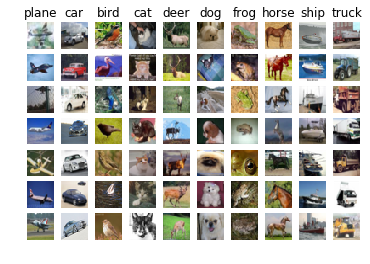

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0: plt.title(cls)
plt.show()

<img src='img/cifar_10_sample.png' width=150%>

**Выделим из 60 тысяч картинок обучающую часть (49к), проверочную (1к) и тестовую (1к).**

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We use the first num_test points of the original test set as our test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)

Train data shape:  (49000, 32, 32, 3)
Validation data shape:  (1000, 32, 32, 3)
Test data shape:  (1000, 32, 32, 3)


**Предобработка данных включает 3 шага:**
 - развернуть все пиксели в одну строку (подход к извлечению признаков из изображения очень простой, можно даже сказать, что топорный)
 - вычислить "среднее изображение" и вычесть его из всех других изображений
 - добавить к признаковому описанию каждого объекта по 1-ке (понадобится чуть позже)

In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


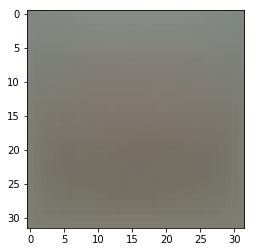

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) 
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape)

(49000, 3073) (1000, 3073) (1000, 3073)


### У нас будет простой линейный классификатор
<img src='img/pixelspace.jpeg'>

**Введем обозначения:**

- $N$ – число объектов (картинок) в обучающей выборке (у нас 49000)
- $D$ – размерность признакового представления картинок (у нас $32 \times 32 \times 3 = 3072$)
- $K$ – число классов в задаче классификации (у нас 10)



**Вначале введем функцию $f$ – оценку принадлежности изображения к классу. Вычислять ее будем линейно:**

$$\Large f(x_i, W, b)=Wx_i+b$$

Здесь:
- $x_i$ – вектор размерности $[D \times 1]$, признаковое описание $i$-ой картинки
- $W$ – матрица размерности $[K \times D]$, параметры (веса), которые надо подобрать
- $b$ – вектор размерности $[K \times 1]$, также параметры, вектор смещения (bias)

<img src='img/imagemap.jpg'>

Небольшой трюк: вектор $\large b$ можно добавить справа к матрице $\large W$, а ко всем $x_i$ добавить снизу по 1-ке, и тогда вычисление функции $\ \large f$ просто сводится к перемножению матрицы и вектора:

$$\large W \leftarrow [W; b]$$

$$\large x_i \leftarrow \begin{bmatrix}
                         x_i \\ 1
                         \end{bmatrix}$$
         
$$\large  f(x_i, W, b)=Wx_i$$

Теперь матрица $W$ имеет размерность $[K \times (D + 1)]$.

**От оценок принадлежности к классам перейдем к условным "вероятностям" отнесения к классам – $\large P(y_i \ | \ x_i, W)$**.

Вспомним, что в модели логистической регрессии мы определяли вероятность наступления события (класс +1) как 

$$\Large P_i^+  = P(y=1 \mid x_i, w) = \frac{1}{1 + e^{-w^Tx}} = \sigma(w^Tx)$$

Обобщение на случай многоклассовой классификации – softmax:

$$\Large P(y_i \mid x_i, W) = \frac{e^{f_{y_i}}}{\sum_{i=1}^Ke^{f_{y_i}}}$$

Можно довольно [легко увидеть](https://stats.stackexchange.com/questions/233658/softmax-vs-sigmoid-function-in-logistic-classifier), что сигмоида в бинарной логистической регрессии – это частный случай softmax. 

Softmax так называется потому, что действительно похож на "сглаженный максимум". Сравните:

$$\large a = \begin{bmatrix} 8 \\ 2 \\ 4 \end{bmatrix},  \quad max(a) = \begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix}, \quad softmax(a) = \begin{bmatrix} 0.979 \\ 0.003 \\ 0.018 \end{bmatrix}$$

Но главное – его можно дифференцировать.

## Функция  потерь softmax
Как обучать веса $\large W$? Введем функцию потерь и будем ее оптимизировать!
Это можно сделать по аналогии с выводом (а вывод – в [этой статье](https://habrahabr.ru/company/ods/blog/323890/)) функции потерь для логистической регрессии на основе принципа максимального правдоподобия (Maximum Likelihood Estimation, MLE):

$$\Large L_i  = -\log  \frac{e^{f_{y_i}}}{\sum_{j=1}^Ke^{f_{j}}}$$
Или, что то же самое, $$\Large L_i = -f_{y_i} + \log \sum_{j=1}^Ke^{f_{j}}$$

Здесь $L_i$ – это функция от обучающего примера, т.е. пары $(x_i, y_i)$, также она зависит от весов $W$ через  $f = Wx_i$. <br>$f_{y_i}$ – компонента вектора $f$ c номером $y_i$, то есть индексом правильного класса для $x_i$.

Также мы добавим регуляризацию весов, $R(W)$. В случае $L_2$-регуляризации это будет соответствовать априорному предположению о нормальном распределении весов, а минимизация функции потерь будет получаться из MAP-оценки (Maximum a posteriori) весов. Подробнее о Байесовском взгляде на машинное обучение можно почитать в  [этой](https://habrahabr.ru/company/ods/blog/322076/) статье, также все описанное выше лаконично (не излишне подробно) описывается в книге ["Deep Learning"](http://www.deeplearningbook.org/) (I. Goodfellow, Y. Bengio, A. Courville) в [5 главе](http://www.deeplearningbook.org/contents/ml.html) первого раздела "Machine Learning Basics".

С добавлением регуляризации функция ошибки будет выглядеть так:

$$L = \frac{1}{N} \sum_{i=1}^N \big( -f_{y_i} + \log \sum_{j=1}^Ke^{f_{j}}\big) + \lambda \sum_{k=1}^K \sum_{l=1}^D W^2_{k,l},$$

где в круглых скобках – функция потерь на одном объекте, $\lambda$ – гиперпараметр.

## Градиент функции потерь softmax

Минимизировать эту функцию (и, соответственно, обучать softmax-классификатор) мы будем с помощью стохастического градиентного спуска. Для этого надо уметь считать градиент функции потерь по весам $\Large \nabla_W L_i$. Это матрица тех же размеров, что и $\Large W$, то есть $[K \times (D + 1)]$. Строки этой матрицы $w_j$ будут соответствовать векторам весов, с помощью которых считается оценка принадлежности к классу $j$. Посчитаем градиент $L_i$ по этим векторам:

$$\Large \frac{\partial L_i}{\partial w_j} = \frac{\partial L_i}{\partial f_{ij}} \frac{\partial f_{ij}}{\partial w_j} = \big(-\mathbb{1}_{j=y_i} +  \frac{e^{f_j}}{\sum_{j=1}^Ke^{f_{j}}} \big)\ x_{ij},$$

где $f_{ij}$ – $j$-ая компонента вектора $f_i = Wx_i$, а $\mathbb{1}_{j=y_i}$ – индикаторная функция (еще ее называют дельтой Кронекера), попросту 1, если выражение справедливо, 0 в противном случае.

Тогда с учетом регуляризации:

$$\Large \frac{\partial L}{\partial w_j} =  \frac{1}{N} \sum_{i=1}^N \big(-\mathbb{1}_{j=y_i} +  \frac{e^{f_j}}{\sum_{j=1}^Ke^{f_{j}}} \big)\ x_{ij} + 2 \lambda \sum_{l=1}^D w_{jl}$$

## Объединяем все вместе 

Псевдокод алгоритма следующий:

**Обучение**
- **Вход:**
 - Матрица $\large X$ размерности $[N \times D]$, где $N$ – число объектов, $D$ – размерность каждой из них (уже на входе учли столбец из единиц)
 - Вектор $\large y$ с метками классов от 0 до $K-1$
 - $\eta$ – темп обучения (`learning rate`)
 - $\lambda$ – коэффициент регуляризации (`reg`)
 - $T$ – число итеграций градиентного спуска (`num_iters`)
 - $M$ – размер батча, числа объектов, по которым на каждом шаге будут обновляться веса (`batch_size`)
- Инициализируем матрицу весов $W$ (размерность $[D \times K]$) малыми случайными числами из нормального распределения

- В цикле из $T$ итераций:
 - Берем случайные $M$ индексов обучающей выборки и, соотв-но, $X_{batch}$ и $y_{batch}$ – $M$ штук объектов и их меток
 - Считаем матрицу оценок принадлежности объектов из $X_{batch}$ к $K$ классам: $F = X_{batch}W$ 
 - Считаем функцию ошибки, запоминаем ее $$L = \frac{1}{M} \sum_{i=1}^M \big( -F_{iy_i} + \log \sum_{j=1}^Ke^{F_{ij}}\big) + \lambda \sum_{k=1}^K \sum_{l=1}^D W^2_{k,l}$$
 - Считаем градиент функции ошибки $dW$. Для каждого $j$ от 0 до $K-1$: $$ dW_{[:,\ j]} =  \frac{1}{M} \sum_{i=1}^M \big(-\mathbb{1}_{j=y_i} +  \frac{e^{F_{ij}}}{\sum_{j=1}^Ke^{F_{ij}}} \big)\ x_{ij} + 2 \lambda \sum_{l=1}^D w_{jl}$$
 - Обновляем матрицу весов: $$\Large W\ \leftarrow\  W - \eta\ dW$$

**Прогнозирование**
- **Вход:**
 - Матрица $\large X$ размерности $[N \times D]$
- Считаем матрицу оценок принадлежности объектов из $X$ к $K$ классам: $F = XW$ 
- **Выход:**
 - Вектор $p$ длины $N$, где $p_i = \arg\max\limits_{0\leq j \leq K-1}\ F_{ij}$.

## Реализация

Сначала напишем класс `LinearClassifier`, соответствующий линейному классификатору. Далее класс `SoftmaxClassifier` будет его наследником, реализующим нужную функцию потерь и ее градиент.

In [9]:
class LinearClassifier(object):
    
    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, seed=1, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - seed: random seed for reproducibility
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        np.random.seed(seed)
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None
                                                         
            # Sample batch_size elements from the training data and their           
            # corresponding labels to use in this round of gradient descent.        
            idx = np.random.choice(range(X.shape[0]), size=batch_size)
            X_batch = X[idx, :]
            y_batch = y[idx]

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            self.W -= learning_rate * grad 

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[0])
        # choose the class with the highest score 
        y_pred = np.argmax(X.dot(self.W), axis=1)
        return y_pred
  
    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass

В классе `SoftmaxClassifier` будет как простая реализация функции потерь и ее градиента, с циклами, так и эффективная, векторизованная. 

In [10]:
class SoftmaxClassifier(LinearClassifier):

    def loss(self, X_batch, y_batch, reg):
        return self.softmax_loss_vectorized(self.W, X_batch, y_batch, reg)
    
    def softmax_loss_naive(self, W, X, y, reg):
        """
        Softmax loss function, naive implementation (with loops)

        Inputs have dimension D, there are K classes, and we operate on minibatches
        of N examples.

        Inputs:
        - W: A numpy array of shape (D, K) containing weights.
        - X: A numpy array of shape (N, D) containing a minibatch of data.
        - y: A numpy array of shape (N,) containing training labels; y[i] = k means
        that X[i] has label k, where 0 <= k < K.
        - reg: (float) regularization strength

        Returns a tuple of:
        - loss as single float
        - gradient with respect to weights W; an array of same shape as W
        """
        # Initialize the loss and gradient to zero.
        loss = 0.0
        dW = np.zeros_like(W)

        # Compute the softmax loss and its gradient using explicit loops. 
        num_classes = W.shape[1]
        num_train = X.shape[0]
        for i in range(num_train):
            # classification scores for the current sample, shape (1, num_classes)
            scores = X[i].dot(W)
            # just a scalar value
            correct_class_score = scores[y[i]]
            # compute softmax loss for the current sample
            loss += -correct_class_score + np.log(np.exp(scores).sum())
            # compute gradients w.r.t. to weights for each class separately
            for j in range(num_classes):
                dW[:, j] += np.exp(scores[j]) / np.exp(scores).sum() * X[i, :]
            # the formula for gradients w.r.t. to te weights of the correct class
            # is slightly different http://cs231n.github.io/optimization-1/
            dW[:, y[i]] -= X[i, :]

        loss /= num_train
        loss += reg * np.sum(W * W)

        dW /= num_train
        dW += 2 * reg * W
        return loss, dW


    def softmax_loss_vectorized(self, W, X, y, reg):
        """
        Softmax loss function, vectorized version.

        Inputs and outputs are the same as softmax_loss_naive.
        """
        # Initialize the loss and gradient to zero.
        loss = 0.0
        dW = np.zeros_like(W)
        num_train = X.shape[0]
        num_classes = W.shape[1]

        # Compute the softmax loss and its gradient using no explicit loops. 
        scores = X.dot(W)
        # select in each row i the score at position y[i]
        correct_class_scores = scores[range(num_train), y]
        
        # compute softmax loss
        loss = - correct_class_scores.sum() + np.log(np.exp(scores).sum(axis=1)).sum()
        loss /= num_train
        loss += reg * np.sum(W * W)
        
        # compute softmax derivatives w.r.t. to scores, shape (num_train, num_classes)
        softmax_deriv = (np.exp(scores) / np.exp(scores).sum(axis=1).reshape(-1, 1))
        softmax_deriv[range(num_train), y] -= 1
        
        # compute softmax gradients w.r.t. to weights W, shape (num_features, num_classes)
        dW = X.T.dot(softmax_deriv)
        dW /= num_train
        dW += 2 * reg * W
        return loss, dW

**Настроим гиперпараметры – темп обучения и регуляризацию.**

In [11]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
results = {}
best_val = -1
best_softmax_clf = None
learning_rates = np.linspace(3e-7, 5e-7, 3)
regularization_strengths = np.linspace(5e3, 5e4, 3)

for lr in tqdm(learning_rates):
    for reg in tqdm(regularization_strengths):
        softmax_clf = SoftmaxClassifier()
        _ = softmax_clf.train(X_train, y_train, learning_rate=lr, 
                      reg=reg,
                      num_iters=1500, seed=1, verbose=False)
        y_train_pred = softmax_clf.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = softmax_clf.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_acc, val_acc)
        print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_acc, val_acc))
        if val_acc > best_val:
            best_val = val_acc
            best_softmax_clf = softmax_clf

    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

 33%|███▎      | 1/3 [00:12<00:24, 12.23s/it]

lr 3.000000e-07 reg 5.000000e+03 train accuracy: 0.373592 val accuracy: 0.375000



 67%|██████▋   | 2/3 [00:25<00:12, 12.59s/it]

lr 3.000000e-07 reg 2.750000e+04 train accuracy: 0.323980 val accuracy: 0.338000



  0%|          | 0/3 [00:00<?, ?it/s]

lr 3.000000e-07 reg 5.000000e+04 train accuracy: 0.306041 val accuracy: 0.317000



 33%|███▎      | 1/3 [00:11<00:22, 11.42s/it]

lr 4.000000e-07 reg 5.000000e+03 train accuracy: 0.372673 val accuracy: 0.371000



 67%|██████▋   | 2/3 [00:23<00:11, 11.84s/it]

lr 4.000000e-07 reg 2.750000e+04 train accuracy: 0.322204 val accuracy: 0.339000



  0%|          | 0/3 [00:00<?, ?it/s]

lr 4.000000e-07 reg 5.000000e+04 train accuracy: 0.304082 val accuracy: 0.317000



 33%|███▎      | 1/3 [00:11<00:23, 11.73s/it]

lr 5.000000e-07 reg 5.000000e+03 train accuracy: 0.371714 val accuracy: 0.370000



 67%|██████▋   | 2/3 [00:23<00:11, 11.88s/it]

lr 5.000000e-07 reg 2.750000e+04 train accuracy: 0.320551 val accuracy: 0.336000



100%|██████████| 3/3 [01:49<00:00, 36.44s/it]

lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.301245 val accuracy: 0.319000
best validation accuracy achieved during cross-validation: 0.375000


**Теперь проверим качество на тестовой выборке.**

In [12]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax_clf.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.376000


**Напоследок нарисуем выученные веса для каждого класса, "свернув" их обратно в картинки**

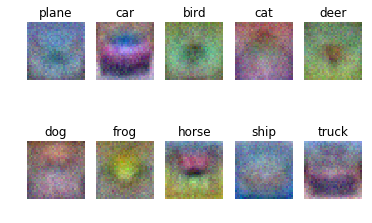

In [13]:
# Visualize the learned weights for each class
w = best_softmax_clf.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])
plt.savefig('img/cifar_template_matching.png', dpi=300)

<img src='img/cifar_template_matching.png' width=150%>